# Test/Debuger for the predict.py file

# TODO 
1. evaluation metrics - IOU for the mask 
2. can do this on a single image to start; start with train dataset to ensure model is working
3. use the data loader to load an image
4. evaluation at scale: create another dataloader; creates batches; apply your model to a batch; extract the eval metrics
5. set up weights and biases/comet 

In [53]:
import os
import torch
import segmentation_models_pytorch as smp
import yaml
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import json
from PIL import Image, ImageOps
import numpy as np

In [61]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation to apply to the image
transform = Compose([
    Resize((224, 224)), ToTensor(),  # Convert the image to a tensor
])

In [62]:
# Load the config file
config_path = '../runs/unet_smp/demo_run/config/config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract values from the config
checkpoint_path = os.path.join(config['path_checkpoints'], 'checkpoint_epoch100.pth')
data_root = config['path_data']
image_size = config['image_size']
in_channels = config['in_channels']
out_channels = config['out_channels']
encoder_name = config['encoder_name']
encoder_weights = config['encoder_weights']
image_folder = os.path.join(config['path_data'], 'images')

In [63]:
# Load the pre-trained model with checkpoint
model = smp.Unet(
    encoder_name=encoder_name,                   # Encoder architecture, e.g., resnet34
    encoder_weights=encoder_weights,             # Pre-trained weights from ImageNet
    in_channels=in_channels,                     # Number of input channels (3 for RGB)
    out_channels=out_channels,                   # Number of output channels (1 for binary)
    activation='sigmoid'                         # Sigmoid activation for binary segmentation
)
model = model.to(device)

In [67]:
checkpoint = torch.load(checkpoint_path)
checkpoint

/tmp/ipykernel_133606/4067291856.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


OrderedDict([('encoder.conv1.weight',
              tensor([[[[-6.6277e-03, -7.7019e-03,  7.2344e-03,  ...,  4.3132e-02,
                          2.1960e-02,  1.8625e-02],
                        [ 2.8925e-02,  3.0190e-02,  3.2159e-02,  ...,  3.2723e-02,
                          2.1391e-02,  4.3277e-02],
                        [-2.0377e-03, -3.4615e-02, -6.3444e-02,  ..., -9.6905e-02,
                         -1.2230e-01, -1.1845e-01],
                        ...,
                        [-1.2717e-02, -1.8856e-02, -8.1219e-03,  ...,  2.4575e-02,
                          1.0556e-02,  2.1388e-02],
                        [-1.1788e-03,  8.8980e-03,  3.9747e-02,  ...,  1.0737e-01,
                          7.4782e-02,  5.7783e-02],
                        [ 7.1712e-03,  1.1671e-02,  3.3367e-02,  ...,  9.5203e-02,
                          9.2524e-02,  1.1065e-01]],
              
                       [[-1.3793e-02,  1.0674e-03,  2.4935e-02,  ...,  4.5952e-02,
                        

In [68]:
# Create a custom dataset for validation
annotations_path = os.path.join(data_root, 'annotations/val.json')

with open(annotations_path) as f:
    annotations = json.load(f)

# Extract relevant parts of the annotations
image_annotations = {annotation['image_id']: annotation for annotation in annotations['annotations']}
image_info = {image['id']: image for image in annotations['images']}

# Load the model weights from checkpoint
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_133606/2749269152.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [70]:
# Function to get the annotation for an image by its ID
def get_annotation_by_image_id(image_id):
    return image_annotations.get(image_id, None)

# Function to predict based on an image (DEBUGGING HERE)
def predict(image_path, transform, model, device):
    image = Image.open(image_path).convert("RGB") # open image
    image_tensor = transform(image).unsqueeze(0).to(device)/255  # apply transformation
    
    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
    
    # Sigmoid for binary segmentation (if required)
    output_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Move output back to CPU for visualization
    
    return output, output_mask


In [78]:
# Example usage
image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/07252023PANB0201.JPG' # from val  
#image_path ='/mnt/class_data/group2/alexandradigiacomo/dataset/images/07202023PANB0201.JPG' # from train

output, output_mask = predict(image_path, transform, model, device)


In [ ]:
# use dataloader to import an image and see what you get 
# see range of masks for display problems

In [79]:
print(f"Non-zero pixels in mask: {np.count_nonzero(output_mask)}")
print(f"Unique values in mask: {np.unique(output_mask)}")
print(f"Mask stats: min={output_mask.min()}, max={output_mask.max()}, mean={output_mask.mean()}, std={output_mask.std()}")


Non-zero pixels in mask: 50176
Unique values in mask: [0.5        0.50000006 0.5000001  0.5000002  0.5000004  0.5000005
 0.5000007  0.50000113 0.50000125 0.50000143 0.5000025  0.5000026
 0.50000286 0.5000043  0.500005   0.5000073  0.50000894 0.5000099
 0.50001556 0.50001675 0.5000192  0.5000241  0.5000379  0.5000566
 0.50006187 0.5000793  0.50010276 0.50010896 0.5001174  0.5001317
 0.5001406  0.50016576 0.5002851  0.5003551  0.50037104 0.50042015
 0.50046    0.50058705 0.50065774 0.50066936 0.50072837 0.5008756
 0.5008844  0.5008861  0.50089175 0.5008921  0.50089675 0.50089824
 0.5008987  0.50090355 0.50090456 0.5009062  0.5009063  0.50090873
 0.5009136  0.500914   0.5009156  0.5009165  0.5009181  0.5009274
 0.50093365 0.50093406 0.50093454 0.50093794 0.50093836 0.5009397
 0.5009403  0.5009419  0.5009451  0.50094527 0.50094837 0.50095
 0.50095165 0.50095177 0.50095636 0.5009567  0.5009568  0.50095826
 0.50095975 0.50096333 0.5009634  0.50096494 0.5009656  0.5009663
 0.500967   0.500968

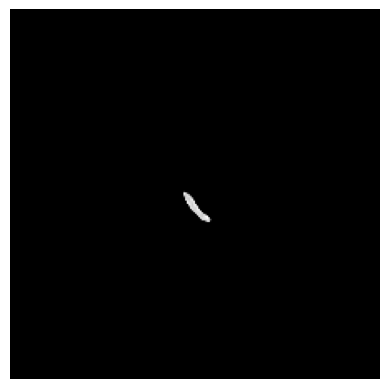

In [83]:
# Example visualization
output_display = output.cpu().squeeze().numpy()
output_mask_display = output

#img_display = img_tensor.numpy().transpose(1, 2, 0) # Convert to (H, W, C)
# mask plot

plt.imshow(output_display, cmap='gray')  # Use 'gray' colormap for mask
plt.axis('off') 

plt.show()